## Kickstarter Project Exploration

Explore cancer projects from Kickstarter

In [1]:
import os.path as op

import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import ttest_ind

import statsmodels.api as sm

In [2]:
DATA_PROCESSED = '../data/processed'

In [3]:
with open(op.join(DATA_PROCESSED, 'cancer_project_text.json'), 'r') as f:
    text_data = json.load(f)

This json file comes from `src/data/data_download.py`.

In [4]:
with open(op.join(DATA_PROCESSED, 'cancer_project_data.json'), 'r') as f:
    json_data = json.load(f)

In [5]:
data = pd.DataFrame(json_data)

data = data.drop_duplicates(subset='id')
data = data[data['id'].isin(list(text_data.keys()))]

data['usd_pledged'] = data['usd_pledged'].astype(float)
data['deadline'] = pd.to_datetime(data['deadline'], unit='s')
data['created_at'] = pd.to_datetime(data['created_at'], unit='s')
data['launched_at'] = pd.to_datetime(data['launched_at'], unit='s')

data.sample(5)

,backers_count,blurb,category_slug,country,created_at,currency,current_currency,deadline,geo_type,goal,id,launched_at,pledged,spotlight,staff_pick,state,status,status_changed_at,url,usd_pledged
330,173,With Grace B. Bold™ is a luxurious collection ...,fashion/apparel,US,2017-06-28 18:37:11,USD,USD,2017-11-13 04:59:00,Town,35000,2013121773,2017-10-01 13:00:04,35251.00,True,False,OH,successful,1510549141,https://www.kickstarter.com/projects/758146846...,35251.00
150,1,Help fund the 1st month of podcasts to offer s...,publishing/radio & podcasts,US,2017-03-13 13:26:58,USD,USD,2017-03-20 15:43:44,Town,2500,1312205664,2017-03-13 15:43:44,150.00,False,False,TX,failed,1490024624,https://www.kickstarter.com/projects/558516877...,150.00
144,6,Hollywood Newest Fashion Sensation. Exclusive ...,fashion/accessories,US,2014-07-30 02:09:08,USD,USD,2014-11-08 05:24:35,Town,150000,1276765651,2014-09-24 04:24:35,33.00,False,False,CA,failed,1415424275,https://www.kickstarter.com/projects/192854814...,33.00
164,124,We're transforming the image of cancer and bre...,comics,US,2012-01-16 15:49:06,USD,USD,2012-05-22 00:01:59,Town,5500,147573601,2012-04-20 00:01:59,6240.09,True,False,CA,successful,1337644919,https://www.kickstarter.com/projects/kaylinmar...,6240.09
68,0,I'm a business owner & former chef. I have an ...,food/food trucks,US,2017-11-17 15:16:52,USD,USD,2018-01-31 02:18:18,Town,25000,215789301,2017-12-02 02:18:18,0.00,False,False,NY,failed,1517365098,https://www.kickstarter.com/projects/203003512...,0.00


In [6]:
len(json_data), data.shape

(472, (455, 20))

Clean out projects not classified as Success or Fail

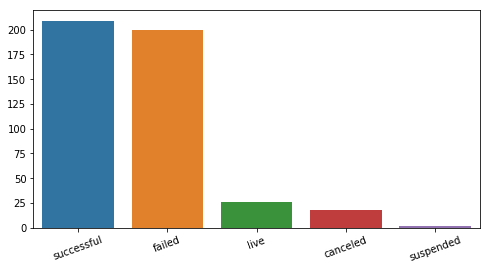

In [7]:
cnt = data['status'].value_counts()
plt.subplots(figsize=(8,4))
sns.barplot(cnt.index, cnt.values)
plt.xticks(rotation=20);

In [8]:
data = data[data['status'].isin(['successful', 'failed'])]
data.shape

(409, 20)

Percent spotlight: 54.09%


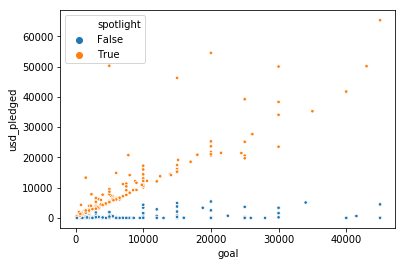

In [9]:
sub_data = data[data['goal'] < 50000]
print(f"Percent spotlight: {sub_data['spotlight'].mean()*100:.2f}%")
sns.scatterplot(sub_data['goal'], sub_data['usd_pledged'], hue=sub_data['spotlight'], s=12)

Welsh's t-test of spotlight (true or false) distributions

What exactly is spotlight? Has a pretty significant correlation with pledged to goal ratio. Doesn't take into account currency conversions but these should be negligible for now.

In [10]:
spotlight_true = sub_data[sub_data['spotlight'] == True]
spotlight_true = (spotlight_true['usd_pledged'] / spotlight_true['goal']).values
spotlight_false = sub_data[sub_data['spotlight'] == False]
spotlight_false = (spotlight_false['usd_pledged'] / spotlight_false['goal']).values

ttest_ind(spotlight_true, spotlight_false, equal_var=False)

Ttest_indResult(statistic=19.276260866752335, pvalue=1.5106371238579e-48)

Percent staff pick: 5.01%


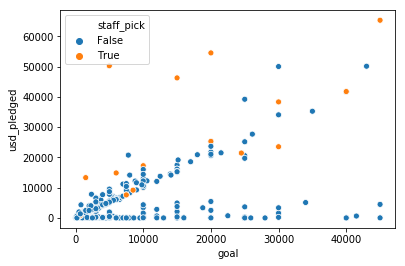

In [11]:
print(f"Percent staff pick: {sub_data['staff_pick'].mean()*100:.2f}%")
sns.scatterplot(sub_data['goal'], sub_data['usd_pledged'], hue=sub_data['staff_pick'])

Welsh's t-test of staff-pick (true or false) distributions

In [12]:
staff_pick_true = sub_data[sub_data['staff_pick'] == True]
staff_pick_true = (staff_pick_true['pledged'] / staff_pick_true['goal']).values
staff_pick_false = sub_data[sub_data['staff_pick'] == False]
staff_pick_false = (staff_pick_false['pledged'] / staff_pick_false['goal']).values

ttest_ind(staff_pick_true, staff_pick_false, equal_var=False)

Ttest_indResult(statistic=2.634838875291475, pvalue=0.01674144505617373)

Popular Country of Origin

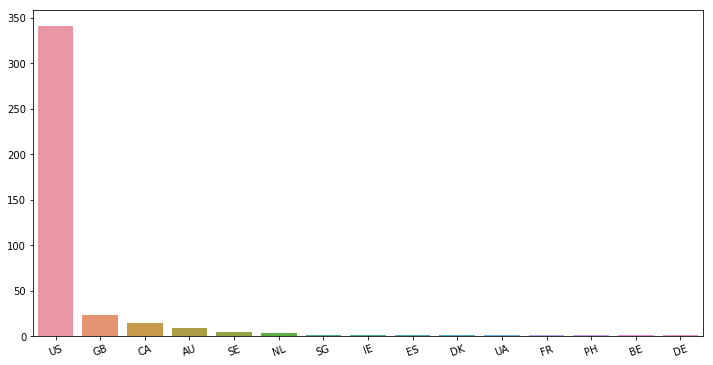

In [13]:
cnt = data['country'].value_counts()
plt.subplots(figsize=(12,6))
sns.barplot(cnt.index, cnt.values)
plt.xticks(rotation=20);

Popular Project Categories

TODO: Aggregate less popular categories into larger supersets.

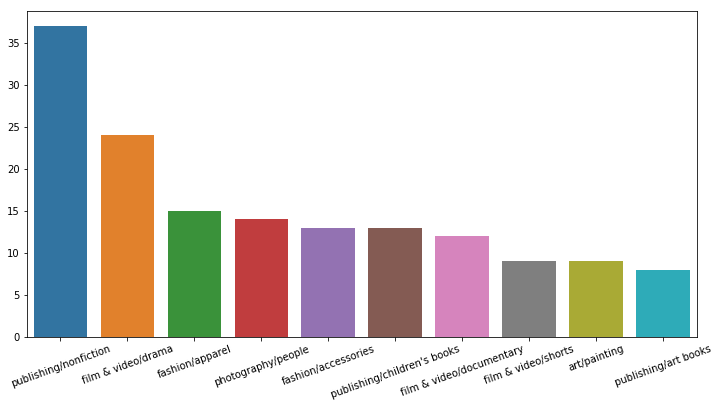

In [14]:
cnt = data['category_slug'].value_counts().nlargest(10)
plt.subplots(figsize=(12,6))
sns.barplot(cnt.index, cnt.values)
plt.xticks(rotation=20);

Geo Types

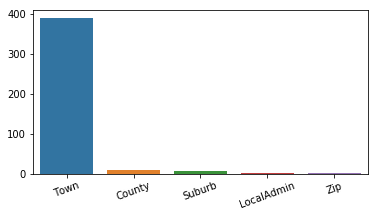

In [15]:
cnt = data['geo_type'].value_counts()
plt.subplots(figsize=(6,3))
sns.barplot(cnt.index, cnt.values)
plt.xticks(rotation=20);

Average Duration

In [16]:
pd.Timedelta(np.median(data['deadline'] - data['launched_at']))

Timedelta('30 days 00:00:00')

Maximum Duration

In [17]:
pd.Timedelta(np.max(data['deadline'] - data['launched_at']))

Timedelta('89 days 17:06:15')